In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
quora = pd.read_csv('quora.csv')

In [9]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
#просто превращаем текст в список символов
def str2list(text):
    return [s for s in text]

In [11]:
quora['preprocessing1'] = quora['question_text'].apply(str2list)

In [12]:
vocab = Counter()

for text in quora.preprocessing1:
    vocab.update(text)
    
sym2id = {'UNK':1, 'PAD':0}

for symbol in vocab:
    sym2id[symbol] = len(sym2id)
    
id2sym = {i:sym for sym, i in sym2id.items()}

In [13]:
X = []
for text in quora.preprocessing1:
    ids = [sym2id.get(symbol, 1) for symbol in text]
    X.append(ids)
    
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 5)

In [14]:
y = quora.target.values

In [15]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [16]:
inputs = tf.keras.layers.Input(shape=(int(MAX_LEN),))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=100)(inputs)
convs = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='same', strides=1)(drop1)
conv2 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(conv2)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(conv3)
pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv4)
convs.append(pool1)

drop2 = tf.keras.layers.Dropout(0.1)(embeddings)
conv5 =  tf.keras.layers.Conv1D(kernel_size=10, filters=5, padding='same', strides=1)(drop2)
pool2 = tf.compat.v1.keras.layers.MaxPool1D()(conv5)
convs.append(pool2)

drop3 = tf.keras.layers.Dropout(0.1)(embeddings)
conv6 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(drop3)
conv7 = tf.keras.layers.Conv1D(kernel_size=7, filters=5, padding='same', strides=1)(conv6)
pool3 = tf.compat.v1.keras.layers.MaxPool1D()(conv7)
convs.append(pool3)

drop4 = tf.keras.layers.Dropout(0.2)(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(drop4)
pool4 = tf.compat.v1.keras.layers.MaxPool1D()(conv8)
convs.append(pool4)

concat = tf.keras.layers.concatenate(convs, axis=1)
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [17]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
          epochs=5)

Epoch 1/5
311/311 [==============================] - 58s 186ms/step - loss: 0.2089 - f1: 0.0395 - val_loss: 0.1814 - val_f1: 0.1413
Epoch 2/5
311/311 [==============================] - 56s 179ms/step - loss: 0.1767 - f1: 0.1647 - val_loss: 0.1730 - val_f1: 0.2695
Epoch 3/5
311/311 [==============================] - 56s 180ms/step - loss: 0.1696 - f1: 0.2225 - val_loss: 0.1810 - val_f1: 0.3579
Epoch 4/5
311/311 [==============================] - 56s 179ms/step - loss: 0.1667 - f1: 0.2459 - val_loss: 0.1783 - val_f1: 0.3720
Epoch 5/5
311/311 [==============================] - 55s 178ms/step - loss: 0.1640 - f1: 0.2716 - val_loss: 0.1773 - val_f1: 0.3989


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


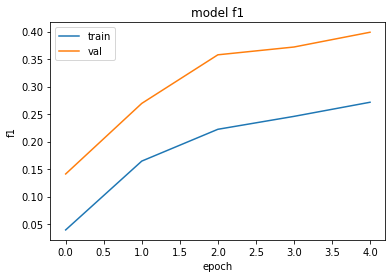

In [18]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Продолжает довольно стабильно расти: видимо, пяти эпох мало

In [19]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
          epochs=10)

Epoch 1/10
311/311 [==============================] - 55s 177ms/step - loss: 0.1623 - f1: 0.2844 - val_loss: 0.1993 - val_f1: 0.4280
Epoch 2/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1607 - f1: 0.2978 - val_loss: 0.1716 - val_f1: 0.4178
Epoch 3/10
311/311 [==============================] - 54s 175ms/step - loss: 0.1595 - f1: 0.3070 - val_loss: 0.1676 - val_f1: 0.3521
Epoch 4/10
311/311 [==============================] - 55s 177ms/step - loss: 0.1584 - f1: 0.3165 - val_loss: 0.1767 - val_f1: 0.3995
Epoch 5/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1565 - f1: 0.3255 - val_loss: 0.1621 - val_f1: 0.3727
Epoch 6/10
311/311 [==============================] - 55s 178ms/step - loss: 0.1556 - f1: 0.3323 - val_loss: 0.1665 - val_f1: 0.3991
Epoch 7/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1542 - f1: 0.3434 - val_loss: 0.1659 - val_f1: 0.3063
Epoch 8/10
311/311 [==============================] - 55s 175ms/step 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


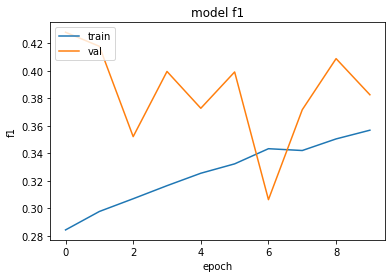

In [20]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Результат, когда не получилось превзойти стартовый результат на val, не очень хороший

Попробуем изменить предобработку: оставим только английские буквы и приведем все к нижнему регистру

In [21]:
import re

In [24]:
def str2list(text):
    text = text.lower()
    text = re.sub('[^a-z]', '', text)
    return [s for s in text]

In [25]:
quora['preprocessing2'] = quora['question_text'].apply(str2list)

Для всех оставшихся символов у нас уже есть индексы

In [28]:
X = []
for text in quora.preprocessing2:
    ids = [sym2id.get(symbol, 1) for symbol in text]
    X.append(ids)
    
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)


In [29]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
          epochs=10)

Epoch 1/10
311/311 [==============================] - 59s 189ms/step - loss: 0.1769 - f1: 0.1824 - val_loss: 0.1859 - val_f1: 0.3186
Epoch 2/10
311/311 [==============================] - 55s 178ms/step - loss: 0.1690 - f1: 0.2440 - val_loss: 0.1764 - val_f1: 0.2828
Epoch 3/10
311/311 [==============================] - 55s 177ms/step - loss: 0.1669 - f1: 0.2604 - val_loss: 0.1745 - val_f1: 0.3151
Epoch 4/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1652 - f1: 0.2676 - val_loss: 0.1919 - val_f1: 0.3599
Epoch 5/10
311/311 [==============================] - 66s 213ms/step - loss: 0.1639 - f1: 0.2797 - val_loss: 0.1760 - val_f1: 0.2940
Epoch 6/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1626 - f1: 0.2859 - val_loss: 0.1958 - val_f1: 0.3517
Epoch 7/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1616 - f1: 0.2957 - val_loss: 0.1777 - val_f1: 0.3582
Epoch 8/10
311/311 [==============================] - 55s 176ms/step 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


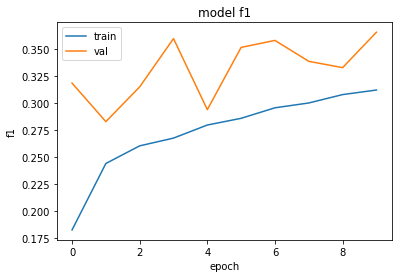

In [30]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Хотя результат после 10-й эпохи практически такой же, это больше похоже на улучшение качества по сравнению с начальным состоянием

Попробуем везде убрать pool

In [31]:
inputs = tf.keras.layers.Input(shape=(int(MAX_LEN),))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=100)(inputs)
convs = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='same', strides=1)(drop1)
conv2 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(conv2)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(conv3)
convs.append(conv4)

drop2 = tf.keras.layers.Dropout(0.1)(embeddings)
conv5 =  tf.keras.layers.Conv1D(kernel_size=10, filters=5, padding='same', strides=1)(drop2)
convs.append(conv5)

drop3 = tf.keras.layers.Dropout(0.1)(embeddings)
conv6 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(drop3)
conv7 = tf.keras.layers.Conv1D(kernel_size=7, filters=5, padding='same', strides=1)(conv6)
convs.append(conv7)

drop4 = tf.keras.layers.Dropout(0.2)(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(drop4)
convs.append(conv8)

concat = tf.keras.layers.concatenate(convs, axis=1)
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [32]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
          epochs=10)

Epoch 1/10
311/311 [==============================] - 67s 214ms/step - loss: 0.2202 - f1: 4.4969e-04 - val_loss: 0.2114 - val_f1: 0.0000e+00
Epoch 2/10
311/311 [==============================] - 62s 199ms/step - loss: 0.2091 - f1: 1.0439e-04 - val_loss: 0.2061 - val_f1: 0.0000e+00
Epoch 3/10
311/311 [==============================] - 57s 182ms/step - loss: 0.2021 - f1: 1.0520e-04 - val_loss: 0.2011 - val_f1: 0.0000e+00
Epoch 4/10
311/311 [==============================] - 57s 182ms/step - loss: 0.1985 - f1: 2.3840e-04 - val_loss: 0.1983 - val_f1: 0.0000e+00
Epoch 5/10
311/311 [==============================] - 62s 200ms/step - loss: 0.1969 - f1: 9.1762e-04 - val_loss: 0.1969 - val_f1: 0.0038
Epoch 6/10
311/311 [==============================] - 59s 189ms/step - loss: 0.1957 - f1: 0.0034 - val_loss: 0.1980 - val_f1: 0.0058
Epoch 7/10
311/311 [==============================] - 56s 182ms/step - loss: 0.1942 - f1: 0.0157 - val_loss: 0.1962 - val_f1: 0.0133
Epoch 8/10
311/311 [=============

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


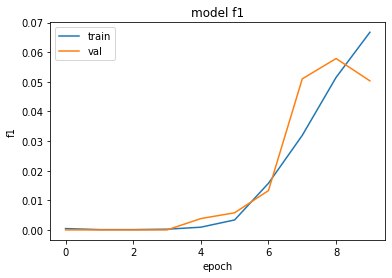

In [33]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Результат отвратительный. Попробуем, наоборот, добавить max_pool после каждого слоя, а не только в самом конце

In [37]:
inputs = tf.keras.layers.Input(shape=(int(MAX_LEN),))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=100)(inputs)
convs = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='same', strides=1)(drop1)
pool1 = pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv1)
conv2 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(pool1)
pool2 = pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv2)
conv3 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(pool2)
pool3 = pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv3)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(pool3)
pool4 = tf.compat.v1.keras.layers.MaxPool1D()(conv4)
convs.append(pool4)

drop2 = tf.keras.layers.Dropout(0.1)(embeddings)
conv5 =  tf.keras.layers.Conv1D(kernel_size=10, filters=5, padding='same', strides=1)(drop2)
pool5 = tf.compat.v1.keras.layers.MaxPool1D()(conv5)
convs.append(pool5)

drop3 = tf.keras.layers.Dropout(0.1)(embeddings)
conv6 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(drop3)
pool6 = tf.compat.v1.keras.layers.MaxPool1D()(conv6)
conv7 = tf.keras.layers.Conv1D(kernel_size=7, filters=5, padding='same', strides=1)(pool6)
pool7 = tf.compat.v1.keras.layers.MaxPool1D()(conv7)
convs.append(pool7)

drop4 = tf.keras.layers.Dropout(0.2)(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(drop4)
pool8 = tf.compat.v1.keras.layers.MaxPool1D()(conv8)
convs.append(pool8)

concat = tf.keras.layers.concatenate(convs, axis=1)
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [38]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
          epochs=10)

Epoch 1/10
311/311 [==============================] - 61s 197ms/step - loss: 0.2127 - f1: 4.0372e-04 - val_loss: 0.1828 - val_f1: 9.7674e-04
Epoch 2/10
311/311 [==============================] - 54s 175ms/step - loss: 0.1764 - f1: 0.1275 - val_loss: 0.1742 - val_f1: 0.2779
Epoch 3/10
311/311 [==============================] - 54s 174ms/step - loss: 0.1683 - f1: 0.2380 - val_loss: 0.1660 - val_f1: 0.3208
Epoch 4/10
311/311 [==============================] - 53s 172ms/step - loss: 0.1639 - f1: 0.2715 - val_loss: 0.1636 - val_f1: 0.3055
Epoch 5/10
311/311 [==============================] - 61s 196ms/step - loss: 0.1615 - f1: 0.2869 - val_loss: 0.1672 - val_f1: 0.3824
Epoch 6/10
311/311 [==============================] - 54s 172ms/step - loss: 0.1599 - f1: 0.3033 - val_loss: 0.1650 - val_f1: 0.3856
Epoch 7/10
311/311 [==============================] - 54s 172ms/step - loss: 0.1584 - f1: 0.3118 - val_loss: 0.1647 - val_f1: 0.3979
Epoch 8/10
311/311 [==============================] - 54s 173

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


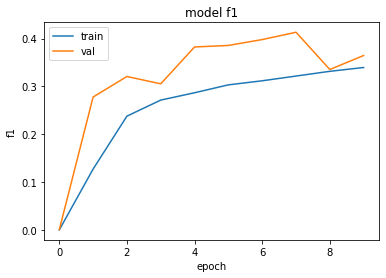

In [39]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Стало лучше, чем было в изначальной конфигурации с выбором максимального значения только в самом конце

Возьмём изначальную конфигурацию и уберём оттуда все drop

In [40]:
inputs = tf.keras.layers.Input(shape=(int(MAX_LEN),))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=100)(inputs)
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='same', strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(conv2)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(conv3)
pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv4)
convs.append(pool1)


conv5 =  tf.keras.layers.Conv1D(kernel_size=10, filters=5, padding='same', strides=1)(embeddings)
pool2 = tf.compat.v1.keras.layers.MaxPool1D()(conv5)
convs.append(pool2)


conv6 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(embeddings)
conv7 = tf.keras.layers.Conv1D(kernel_size=7, filters=5, padding='same', strides=1)(conv6)
pool3 = tf.compat.v1.keras.layers.MaxPool1D()(conv7)
convs.append(pool3)

conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(embeddings)
pool4 = tf.compat.v1.keras.layers.MaxPool1D()(conv8)
convs.append(pool4)

concat = tf.keras.layers.concatenate(convs, axis=1)
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [41]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
          epochs=10)

Epoch 1/10
311/311 [==============================] - 48s 153ms/step - loss: 0.2145 - f1: 0.0011 - val_loss: 0.1885 - val_f1: 0.0023
Epoch 2/10
311/311 [==============================] - 47s 150ms/step - loss: 0.1794 - f1: 0.1113 - val_loss: 0.1790 - val_f1: 0.1134
Epoch 3/10
311/311 [==============================] - 47s 151ms/step - loss: 0.1706 - f1: 0.2144 - val_loss: 0.1736 - val_f1: 0.2926
Epoch 4/10
311/311 [==============================] - 48s 154ms/step - loss: 0.1665 - f1: 0.2507 - val_loss: 0.1678 - val_f1: 0.2617
Epoch 5/10
311/311 [==============================] - 47s 151ms/step - loss: 0.1647 - f1: 0.2604 - val_loss: 0.1696 - val_f1: 0.3167
Epoch 6/10
311/311 [==============================] - 47s 152ms/step - loss: 0.1626 - f1: 0.2794 - val_loss: 0.1765 - val_f1: 0.1442
Epoch 7/10
311/311 [==============================] - 47s 153ms/step - loss: 0.1614 - f1: 0.2856 - val_loss: 0.1680 - val_f1: 0.1941
Epoch 8/10
311/311 [==============================] - 47s 150ms/step 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


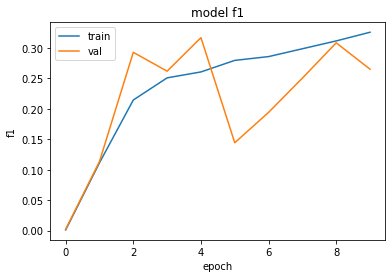

In [42]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

На валидации стало хуже

Оставим drop, но сделаем его в 5 раз меньше

In [43]:
inputs = tf.keras.layers.Input(shape=(int(MAX_LEN),))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=100)(inputs)
convs = []

drop1 = tf.keras.layers.Dropout(0.04)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='same', strides=1)(drop1)
conv2 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(conv2)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(conv3)
pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv4)
convs.append(pool1)

drop2 = tf.keras.layers.Dropout(0.02)(embeddings)
conv5 =  tf.keras.layers.Conv1D(kernel_size=10, filters=5, padding='same', strides=1)(drop2)
pool2 = tf.compat.v1.keras.layers.MaxPool1D()(conv5)
convs.append(pool2)

drop3 = tf.keras.layers.Dropout(0.02)(embeddings)
conv6 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(drop3)
conv7 = tf.keras.layers.Conv1D(kernel_size=7, filters=5, padding='same', strides=1)(conv6)
pool3 = tf.compat.v1.keras.layers.MaxPool1D()(conv7)
convs.append(pool3)

drop4 = tf.keras.layers.Dropout(0.04)(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(drop4)
pool4 = tf.compat.v1.keras.layers.MaxPool1D()(conv8)
convs.append(pool4)

concat = tf.keras.layers.concatenate(convs, axis=1)
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [44]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
          epochs=10)

Epoch 1/10
311/311 [==============================] - 55s 176ms/step - loss: 0.2115 - f1: 0.0117 - val_loss: 0.1875 - val_f1: 0.0646
Epoch 2/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1788 - f1: 0.1392 - val_loss: 0.1746 - val_f1: 0.2196
Epoch 3/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1722 - f1: 0.2059 - val_loss: 0.1755 - val_f1: 0.2674
Epoch 4/10
311/311 [==============================] - 55s 176ms/step - loss: 0.1687 - f1: 0.2351 - val_loss: 0.1789 - val_f1: 0.3280
Epoch 5/10
311/311 [==============================] - 54s 175ms/step - loss: 0.1659 - f1: 0.2570 - val_loss: 0.1810 - val_f1: 0.3557
Epoch 6/10
311/311 [==============================] - 54s 174ms/step - loss: 0.1639 - f1: 0.2741 - val_loss: 0.1682 - val_f1: 0.2762
Epoch 7/10
311/311 [==============================] - 54s 174ms/step - loss: 0.1623 - f1: 0.2829 - val_loss: 0.1657 - val_f1: 0.2775
Epoch 8/10
311/311 [==============================] - 55s 176ms/step 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


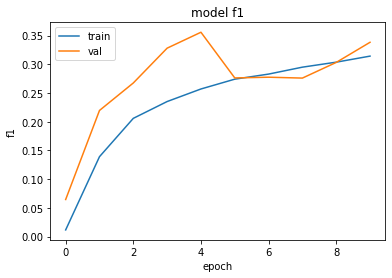

In [45]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Этого оказалось достатоно, чтобы избежать переобучения, но итоговый результат не улучшился

Лучшей из опробованных оказалась модель с максимизацией после каждой свертки. Запустим её с колбеком

In [46]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [47]:
inputs = tf.keras.layers.Input(shape=(int(MAX_LEN),))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=100)(inputs)
convs = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, padding='same', strides=1)(drop1)
pool1 = pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv1)
conv2 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(pool1)
pool2 = pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv2)
conv3 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(pool2)
pool3 = pool1 = tf.compat.v1.keras.layers.MaxPool1D()(conv3)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(pool3)
pool4 = tf.compat.v1.keras.layers.MaxPool1D()(conv4)
convs.append(pool4)

drop2 = tf.keras.layers.Dropout(0.1)(embeddings)
conv5 =  tf.keras.layers.Conv1D(kernel_size=10, filters=5, padding='same', strides=1)(drop2)
pool5 = tf.compat.v1.keras.layers.MaxPool1D()(conv5)
convs.append(pool5)

drop3 = tf.keras.layers.Dropout(0.1)(embeddings)
conv6 = tf.keras.layers.Conv1D(kernel_size=2, filters=10, padding='same', strides=1)(drop3)
pool6 = tf.compat.v1.keras.layers.MaxPool1D()(conv6)
conv7 = tf.keras.layers.Conv1D(kernel_size=7, filters=5, padding='same', strides=1)(pool6)
pool7 = tf.compat.v1.keras.layers.MaxPool1D()(conv7)
convs.append(pool7)

drop4 = tf.keras.layers.Dropout(0.2)(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=5, padding='same', strides=1)(drop4)
pool8 = tf.compat.v1.keras.layers.MaxPool1D()(conv8)
convs.append(pool8)

concat = tf.keras.layers.concatenate(convs, axis=1)
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [48]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=30,
         callbacks=[checkpoint, early_stop])

Epoch 1/30
621/621 [==============================] - ETA: 0s - loss: 0.2009 - f1: 0.0360
Epoch 00001: val_f1 improved from -inf to 0.21356, saving model to model.weights
621/621 [==============================] - 61s 98ms/step - loss: 0.2009 - f1: 0.0360 - val_loss: 0.1791 - val_f1: 0.2136
Epoch 2/30
621/621 [==============================] - ETA: 0s - loss: 0.1732 - f1: 0.1983
Epoch 00002: val_f1 improved from 0.21356 to 0.28121, saving model to model.weights
621/621 [==============================] - 60s 97ms/step - loss: 0.1732 - f1: 0.1983 - val_loss: 0.1679 - val_f1: 0.2812
Epoch 3/30
620/621 [============================>.] - ETA: 0s - loss: 0.1675 - f1: 0.2419
Epoch 00003: val_f1 improved from 0.28121 to 0.34044, saving model to model.weights
621/621 [==============================] - 67s 108ms/step - loss: 0.1675 - f1: 0.2420 - val_loss: 0.1669 - val_f1: 0.3404
Epoch 4/30
621/621 [==============================] - ETA: 0s - loss: 0.1641 - f1: 0.2675
Epoch 00004: val_f1 did not

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


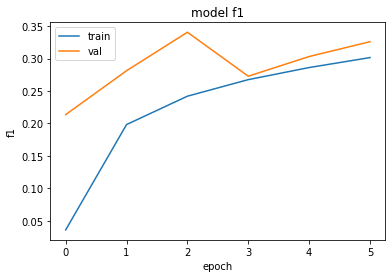

In [49]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Вообще-то мне эта модель не нужна, но что-то подсказывает, что незачем делать checkpoint, если потом не сохраняю модель

In [50]:
model.save_weights('quora_model.weights')